# PII MASKING AND RISK ASSESSMENT IN UNSTRUCTURED TEXT: AN NLP-BASED APPROACH

#### Final Code Submission   
- Eduard Aguado (176199)
- Federico de Marinis (176194)
- Noe Juarez (176695)
- Marco Sburlino (176186)

In [ ]:
# !pip install transformers==4.38.2 datasets evaluate scikit-learn spacy pandas matplotlib seaborn torch --quiet
# !python -m spacy download en_core_web_sm


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     --- ------------------------------------ 1.0/12.8 MB 2.4 MB/s eta 0:00:05
     ---- ----------------------------------- 1.3/12.8 MB 2.4 MB/s eta 0:00:05
     ----- ---------------------------------- 1.8/12.8 MB 2.4 MB/s eta 0:00:05
     ------- -------------------------------- 2.4/12.8 MB 2.4 MB/s eta 0:00:05
     --------- ------------------------------ 2.9/12.8 MB 2.4 MB/s eta 0:00:05
     ---------- ----------------------------- 3.4/12.8 MB 2.4 MB/s eta 0:00:04
     ------------ --------------------------- 3.9/12.8 MB 2.4 MB/s eta 0:00:04
     ------------- -------------------------- 4.5/12.8 MB 2.4 MB/s eta 0:00:04
     --------------- ------------------------ 5.0/12.8 MB 2.4 MB/s eta 0:00:04
     ----------------- ---------------------- 5.5/12.8 MB 2.4 MB/s eta 0:00:04
     ------------------ --------------------- 6.0/12.8 MB 2.4 MB/s


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os
import random
import torch
from datasets import Dataset, load_from_disk, load_dataset

# We fix all sources of randomness so that every time we run this notebook we get the same sample and the same results.
SEED = 23
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


def load_data():
    """
    Load the pii-masking-300k dataset and return train and validation DataFrames.
    """
    ds = load_dataset("ai4privacy/pii-masking-300k") # Load the full dataset (includes train and validation splits)
    return pd.DataFrame(ds["train"]), pd.DataFrame(ds["validation"]) # Convert each split to pandas DataFrame

df_train, df_test = load_data()
print(df_train.columns)

df = pd.concat([df_train, df_test], ignore_index=True) # We merge train and validation sets to have a single DataFrame for processing.

c:\Users\marco\OneDrive\Desktop\MSc Data Science\Natural Language Processing\v1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Index(['source_text', 'target_text', 'privacy_mask', 'span_labels',
       'mbert_text_tokens', 'mbert_bio_labels', 'id', 'language', 'set'],
      dtype='object')


#### Data Sanity-Check
We begin by confirming that the dataset doesn't contain any missing values. Next, we identify and remove any row whose source_text is an empty string. Finally, we detect and drop any exact duplicate source_text entries so that each document in our corpus is unique.

In [2]:
def sanity_check(df):
    """
    Perform basic data cleaning checks and drop invalid rows.
    """
    print(f"\nNumber of total missing values in df:", df.isna().sum().sum()) # Count total missing values across all columns

    empty_mask = df["source_text"].str.strip().eq("") # Create a boolean mask for rows where source_text is empty after stripping
    print(f"Empty strings in source_text in df:", empty_mask.sum())
    df = df[~empty_mask].reset_index(drop=True) # Remove rows flagged by empty_mask

    dups = df["source_text"].duplicated().sum() # We count duplicate source_text entries
    print(f"Duplicate source_text rows in df:", dups)
    df = df.drop_duplicates(subset=["source_text"]).reset_index(drop=True) # Drop duplicate rows based on "source_text"
    
    return df

df = sanity_check(df)


Number of total missing values in df: 0
Empty strings in source_text in df: 25
Duplicate source_text rows in df: 0


In [4]:
def print_language_distribution(df):
    """
    Print the distribution of languages in the DataFrame.
    """
    lang_counts = df["language"].value_counts()
    print("\nLanguages in df:\n", lang_counts) # Display language distribution

print_language_distribution(df)


Languages in df:
 language
English    37854
Name: count, dtype: int64


We restrict our work to English only, as we want to focus on a manageable subset.

In [3]:
df = df[df["language"] == "English"].reset_index(drop=True) # FWe only want to work with English-language documents
print("Training set size:", len(df))

Training set size: 37854


#### PII Entity Type Distribution
This bar chart shows how often each type of sensitive entity (e.g. EMAIL, USERNAME, TIME, etc.) occurs across all training documents. It helps us see which PII categories are most and least common in the data.

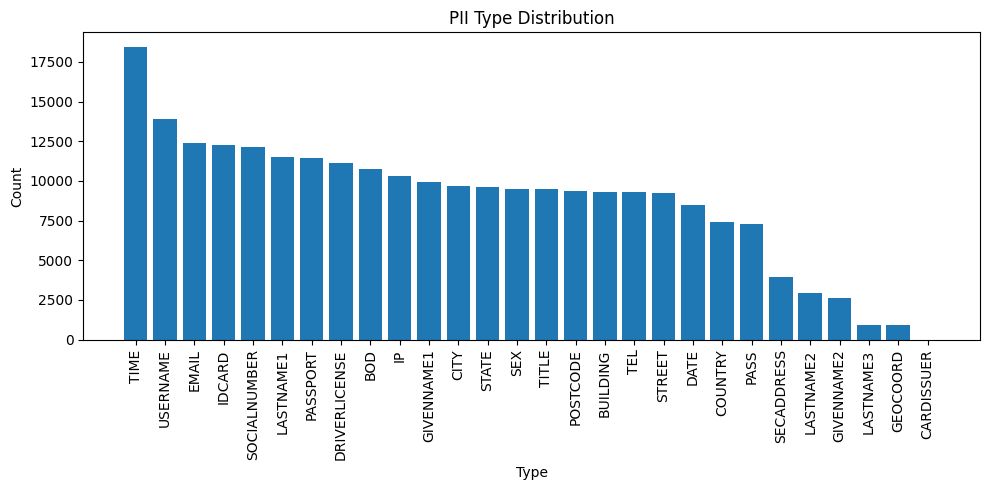

In [5]:
def extract_pii_labels(mask_data):
    """
    Given a list of privacy_mask entries, return a flat list of their label values. 
    """
    labels = []
    for entry in mask_data: 
        records = ast.literal_eval(entry) if isinstance(entry, str) else entry # Convert string representation of list to actual list, if necessary
        labels.extend(rec["label"] for rec in records) # We extract the label from each PII span and add it to the list
    return labels


def plot_bar(series, title, xlabel, rotation=90):
    """
    Plot a bar chart for the given pandas Series using matplotlib.
    """
    plt.figure(figsize=(10, 5))
    plt.bar(series.index.astype(str), series.values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()


labels = extract_pii_labels(df["privacy_mask"]) # Extract and plot how often each PII label occurs across the dataset
plot_bar(pd.Series(labels).value_counts(), "PII Type Distribution", "Type")

#### Number of PII Entities per Document
This histogram displays how many PII spans appear in each document. Most documents contain very few PII entries (0–5/10), while a small number of documents include many more, revealing the long-tailed nature of PII exposure across texts.

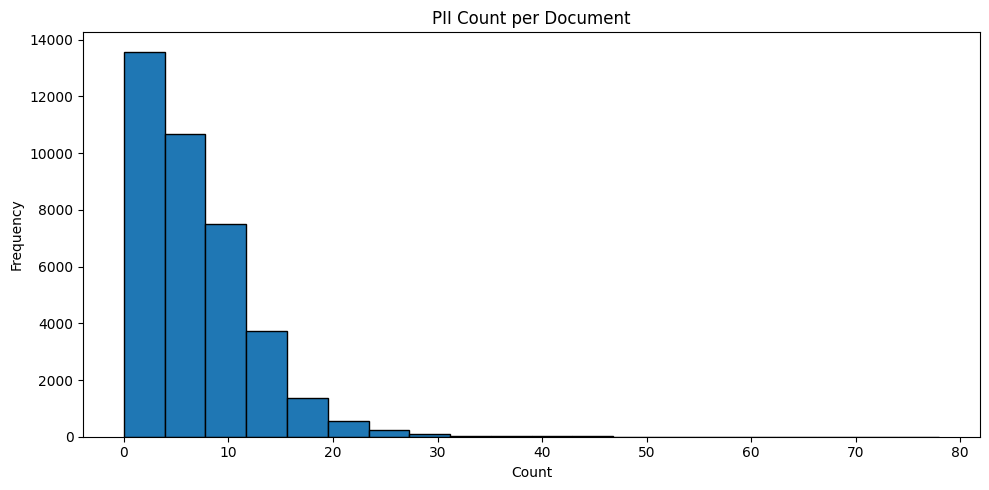

In [6]:
def count_pii_per_doc(mask_data):
    """
    Given a list of privacy_mask entries, return a list of counts of entities per entry.
    """
    counts = []
    for entry in mask_data:
        records = ast.literal_eval(entry) if isinstance(entry, str) else entry # We parse entry into list if it is a string
        counts.append(len(records)) # We append the number of PII spans in this document
    return counts


def plot_hist(data, title, xlabel, bins=30):
    """
    Plot a histogram for the given numeric data using matplotlib.
    """
    plt.figure(figsize=(10, 5))
    plt.hist(data, bins=bins, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


counts = count_pii_per_doc(df["privacy_mask"]) # Plot how many PII spans appear per document — this shows how privacy risk may vary
plot_hist(counts, "PII Count per Document", "Count", bins=20)

#### BIO Label Frequency
This bar chart shows counts for each BIO tag (e.g. B-EMAIL, I-PASSWORD, O, etc.) used in token labeling. The tag “O” (outside) dominates because the vast majority of tokens are not part of any PII entity. In other words, “O” marks regular words and punctuation that should remain unchanged by our NER model.

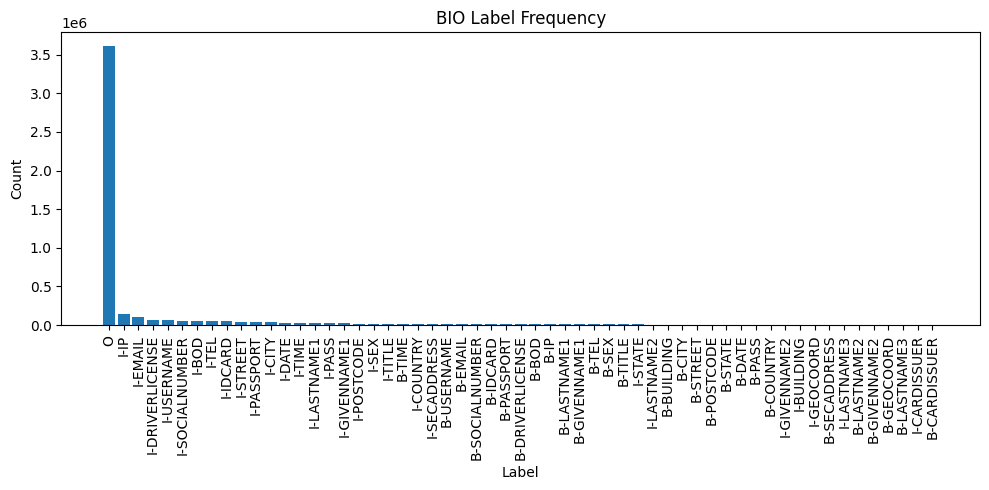

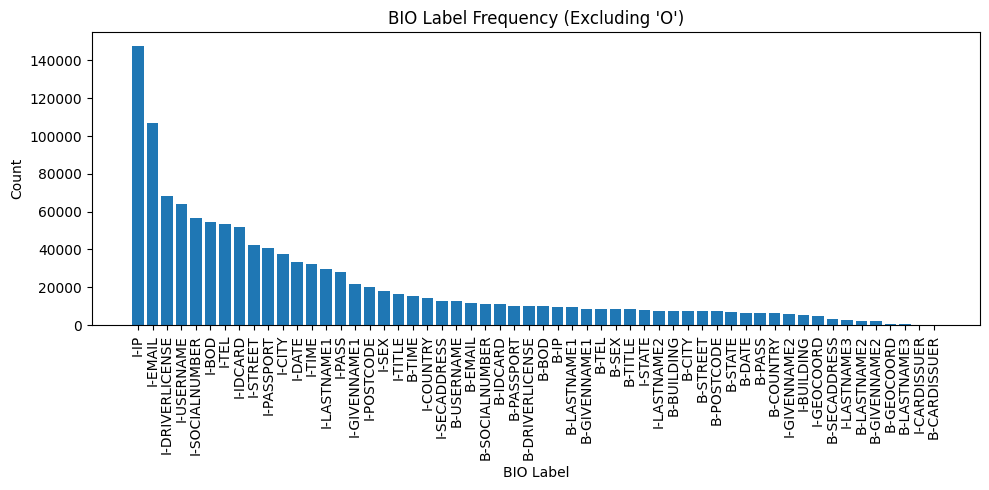

In [7]:
def extract_bio_labels(bio_sequences):
    """
    Flatten a list of BIO label sequences into a single list of labels.
    """
    return [label for seq in bio_sequences for label in seq] # We iterate through each sequence, then through each label, to produce one flat list


bio = extract_bio_labels(df["mbert_bio_labels"]) # Flatten and visualize all BIO tags across the dataset
plot_bar(pd.Series(bio).value_counts(), "BIO Label Frequency", "Label")

bio_series_no_o = pd.Series(bio).value_counts().drop("O") # We plot it again but exclude "O"
plot_bar(bio_series_no_o, title="BIO Label Frequency (Excluding 'O')", xlabel="BIO Label")

In [8]:
# Display a few sample entries to inspect their original text and annotated PII spans
for i in range(3):
    print(f"\nDocument {i} Text:")
    print(df.loc[i, "source_text"])
    print("PII Spans:", df.loc[i, "privacy_mask"])


Document 0 Text:
Subject: Group Messaging for Admissions Process

Good morning, everyone,

I hope this message finds you well. As we continue our admissions processes, I would like to update you on the latest developments and key information. Please find below the timeline for our upcoming meetings:

- wynqvrh053 - Meeting at 10:20am
- luka.burg - Meeting at 21
- qahil.wittauer - Meeting at quarter past 13
- gholamhossein.ruschke - Meeting at 9:47 PM
- pdmjrsyoz1460 
PII Spans: [{'value': 'wynqvrh053', 'start': 287, 'end': 297, 'label': 'USERNAME'}, {'value': '10:20am', 'start': 311, 'end': 318, 'label': 'TIME'}, {'value': 'luka.burg', 'start': 321, 'end': 330, 'label': 'USERNAME'}, {'value': '21', 'start': 344, 'end': 346, 'label': 'TIME'}, {'value': 'qahil.wittauer', 'start': 349, 'end': 363, 'label': 'USERNAME'}, {'value': 'quarter past 13', 'start': 377, 'end': 392, 'label': 'TIME'}, {'value': 'gholamhossein.ruschke', 'start': 395, 'end': 416, 'label': 'USERNAME'}, {'value': '9:47

## Preprocessing, Tokenization, and Risk Label Assignment
In this phase, we prepare each document for downstream analysis by performing standard NLP cleaning steps and calculating risk-related features. We begin by lowercasing all text, stripping whitespace, and removing spacing inconsistencies around punctuation. This helps ensure consistent tokenization and more reliable comparisons between documents.

Next, we tokenize each cleaned sentence using simple whitespace splitting and remove common English stopwords (such as and, the, is), which generally carry less informative value. From this filtered set, we count the number of meaningful tokens per document. We also count how many pieces of personally identifiable information (PII) appear in each document using pre-existing span annotations. Combining the token count and PII span count, we calculate PII density: a rough estimate of how privacy-sensitive a document is.

In [9]:
import re
from math import log
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stop_words = set(ENGLISH_STOP_WORDS) # Use sklearn's built-in English stopword list because nltk was giving dependency issues


# Clean the raw text by lowercasing, trimming, and normalizing punctuation. this step helps ensure consistent tokenization and pattern matching
def basic_clean(text):
    """
    Clean the input text by normalizing case, removing extra spaces, and punctuation.
    """
    text = text.lower().strip() # Lowercase and strip leading and trailing whitespace
    text = re.sub(r"\s+", " ", text) # Collapse multiple spaces into one
    text = re.sub(r"\s+([.,!?;:])", r"\1", text) # Remove space before punctuation
    return text

df["clean_text"] = df["source_text"].apply(basic_clean) # Apply cleaning to every document in the source text
df["white_tokens"] = df["clean_text"].str.split() # Split text into simple whitespace tokens


def remove_stopwords(tokens):
    """
    Remove stopwords from a list of tokens.
    """
    return [token for token in tokens if token not in stop_words]

df["filtered_tokens"] = df["white_tokens"].apply(remove_stopwords)
df["token_count"] = df["filtered_tokens"].apply(len) # Count how many tokens are left after cleaning
df["pii_count"] = count_pii_per_doc(df["privacy_mask"]) # We count how many PII spans are present per document using a utility function
df["pii_density"] = df["pii_count"] / df["token_count"].replace(0, 1) # Number of PII spans per token

Then, we enumerate all possible PII types in the dataset and count how many times each type appears in every document. These are later used to compute a weighted risk score: each PII type is manually assigned a risk weight based on its sensitivity. For example, passwords and passports are more dangerous than first names or email addresses, so they are given higher weights.

The total risk score of a document is simply the weighted sum of PII counts. This allows us to rank or label documents as low or high risk based on a quantitative privacy measure.

In [10]:
pii_types = sorted(set(extract_pii_labels(df["privacy_mask"]))) # We then identify all unique PII types from the entire dataset

# For each PII type, count how many times it appears in each document. We apply a function that checks whether the input is a string or list, parses if needed, and counts matching labels
for pii in pii_types:
    df[f"count_{pii}"] = df["privacy_mask"].apply(
        lambda mask: 
            sum(1 for e in (ast.literal_eval(mask) if isinstance(mask, str) else mask) if e["label"] == pii)
            )

# Manually defined weights based on practical privacy sensitivity of each type. These values reflect real-world risk, not just statistical frequency
pii_weights = {
    "PASSWORD": 3,
    "PASS": 3,
    "SSN": 3,
    "CARDISSUER": 3,
    "DRIVERLICENSE": 3,
    "PASSPORT": 3,
    "IDCARD": 3,
    "EMAIL": 2,
    "TEL": 2,
    "BOD": 2,
    "GIVENNAME1": 2,
    "GIVENNAME2": 2,
    "LASTNAME1": 2,
    "LASTNAME2": 2,
    "LASTNAME3": 2,
    "IP": 2,
    "SECADDRESS": 2,
    "GEOCOORD": 2,
    "USERNAME": 1,
    "TIME": 1,
    "DATE": 1,
    "CITY": 1,
    "STATE": 1,
    "POSTCODE": 1,
    "TITLE": 1,
    "SEX": 1,
    "COUNTRY": 1,
    "BUILDING": 1,
    "STREET": 1
}

In this final step of preprocessing, we turn each document’s numeric risk score into a simple categorical label. These labels reflect whether the document carries more or less privacy risk and will serve as targets for supervised classification in the next phase.

To ensure class balance, we compute a threshold cutoff (the 50th percentile) across all risk scores and assign documents to "Low" or "High" risk based on whether their score falls below or above this median.

In [11]:
df["risk_score"] = 0 # This column will eventually hold the sum of all weighted PII counts per document

for pii in pii_types: # We add the weighted count of each PII type to the overall risk score
    weight = pii_weights.get(pii, 1)  # If a PII type is missing from the weight dictionary, fall back to weight = 1
    df["risk_score"] += df[f"count_{pii}"] * weight

# Convert numeric risk scores to categorical labels ("Low" or "High")
cutoff = np.quantile(df["risk_score"], 0.5) # We assume a cutoff based on the 50th percentiles. Everything below or equal to this is labeled "Low", above it is labeled "High"
df["risk_label"] = df["risk_score"].apply(lambda score: "Low" if score <= cutoff else "High")


print("\nFinal Risk Label Distribution:")
print(df["risk_label"].value_counts())


Final Risk Label Distribution:
risk_label
Low     19892
High    17962
Name: count, dtype: int64


We also visualize the class distribution in both the training and test sets, confirming that the stratified split preserved label proportions and gave us a balanced dataset.

In [12]:
def plot_class_distribution(df_train, df_val, column="risk_label"):
    """
    Plot the class distribution for a specified column in both training and validation sets.
    """
    order = ["Low", "High"]  # Explicit order to match both plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    sns.countplot(x=column, hue=column, data=df_train, ax=axes[0],
                  palette="Blues", legend=False, order=order, hue_order=order)
    axes[0].set_title("Training Set Class Distribution")
    axes[0].set_xlabel("Risk Label")
    axes[0].set_ylabel("Count")

    sns.countplot(x=column, hue=column, data=df_val, ax=axes[1],
                  palette="Blues", legend=False, order=order, hue_order=order)
    axes[1].set_title("Validation Set Class Distribution")
    axes[1].set_xlabel("Risk Label")
    axes[1].set_ylabel("")

    plt.tight_layout()
    plt.show()

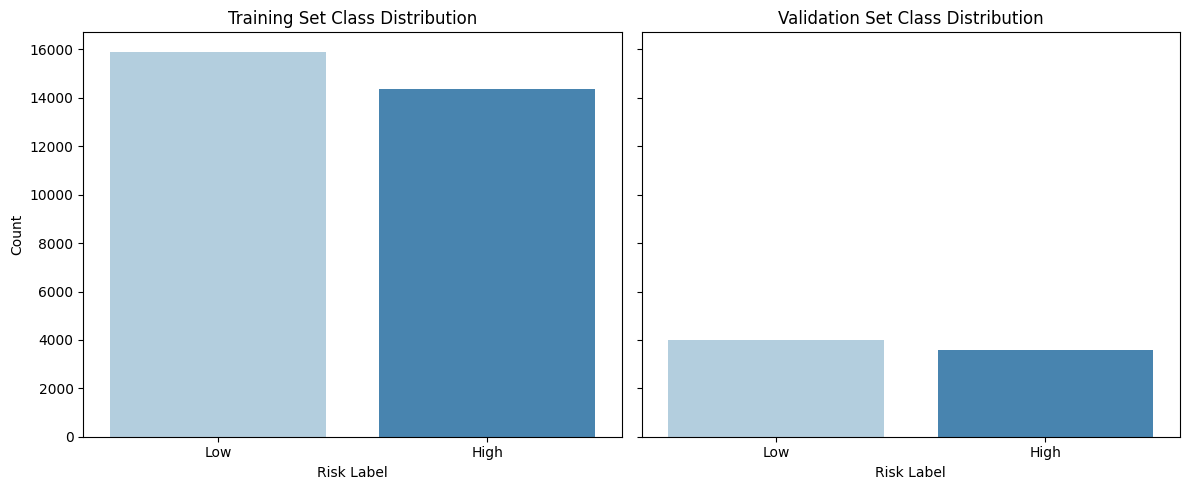

In [13]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split( # We preserve the relative proportion of "Low" and "High" labels in both sets
    df,
    test_size=0.2,
    stratify=df["risk_label"], # Keep class proportions balanced across splits
    random_state=SEED
)

plot_class_distribution(df_train, df_test)

## TF-IDF + Logistic Regression / Naive Bayes
We start by loading the small English SpaCy model, which helps us reduce words to their root form (lemmatization). This makes our vocabulary more compact and meaningful, which improves our classification model later.

We take the filtered tokens from our dataset and turn them into clean, space-separated strings. Each word is lemmatized, meaning we convert it to its base form (e.g., “running” becomes “run”). We save the results as lemma_text for use in text classification.

In [14]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

nlp = spacy.load("en_core_web_sm") # Load SpaCy small English model for lemmatization


def lemmatize_tokens(tokens):
    """
    Lemmatize a list of tokens and return them as a space-separated string.
    """
    doc = nlp(" ".join(tokens)) # Join the list into a string and parse
    return " ".join([token.lemma_ for token in doc if not token.is_punct]) # Remove punctuation and lemmatize

df_train["lemma_text"] = df_train["filtered_tokens"].apply(lemmatize_tokens)
df_test["lemma_text"] = df_test["filtered_tokens"].apply(lemmatize_tokens)

In [15]:
# Separate features and labels for each split
X_train = df_train["lemma_text"]
y_train = df_train["risk_label"]
X_test = df_test["lemma_text"]
y_test = df_test["risk_label"]

This is where we define how text gets turned into numbers. We use TfidfVectorizer to extract features from the text:
- It looks at 1-gram to 3-gram patterns.
- It filters out rare or overly common terms.
- It keeps only the 5,000 most important features.
- It also scales raw frequencies using log-based scaling.

In [16]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 3), # We select unigrams, bigrams, and trigrams
    min_df=1,
    max_df=0.9, # Ignore overly common terms
    stop_words="english", # Remove common English stopwords
    max_features=5000, # Keep top 5000 terms to limit dimensionality
    sublinear_tf=True # Apply log scaling to term frequency
)

In [17]:
def print_metrics(model, X_train, y_train, X_test, y_test, label="Model"):
    """ 
    Print evaluation metrics and confusion matrix for the given model and datasets.
    """
    print(f"\nEvaluation for: {label}\n")

    # Predict on both sets
    preds_train = model.predict(X_train)
    preds_test = model.predict(X_test)

    # Define a helper to print metrics and plot confusion matrix
    def evaluate(y_true, y_pred, dataset_name):
        """
        Print evaluation metrics and confusion matrix for a given dataset.
        """
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average="macro")
        rec = recall_score(y_true, y_pred, average="macro")
        f1 = f1_score(y_true, y_pred, average="macro")

        print(f"\n{dataset_name} Metrics")
        print(f"Accuracy: {acc:.3f}")
        print(f"Macro Precision: {prec:.3f}")
        print(f"Macro Recall: {rec:.3f}")
        print(f"Macro F1 Score: {f1:.3f}")
        print("\nDetailed Classification Report:")
        print(classification_report(y_true, y_pred, digits=3))
        print()

        # Confusion matrix plot
        cm = confusion_matrix(y_true, y_pred, labels=["Low", "High"])
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Low", "High"], yticklabels=["Low", "High"])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"{dataset_name} Confusion Matrix")
        plt.show()

    # Evaluate both training and validation
    evaluate(y_train, preds_train, "Training Set")
    evaluate(y_test, preds_test, "Test Set")

We create a machine learning pipeline using:
- TfidfVectorizer to convert the lemmatized text into numerical feature vectors based on term frequency–inverse document frequency.
- LogisticRegression to classify documents into Low or High privacy risk.

We apply L1 regularization, which promotes sparsity by automatically removing weak features. This helps simplify the model and avoid overfitting, especially when working with high-dimensional TF-IDF data.


Evaluation for: Logistic Regression


Training Set Metrics
Accuracy: 0.851
Macro Precision: 0.851
Macro Recall: 0.850
Macro F1 Score: 0.851

Detailed Classification Report:
              precision    recall  f1-score   support

        High      0.850     0.834     0.842     14370
         Low      0.852     0.867     0.860     15913

    accuracy                          0.851     30283
   macro avg      0.851     0.850     0.851     30283
weighted avg      0.851     0.851     0.851     30283




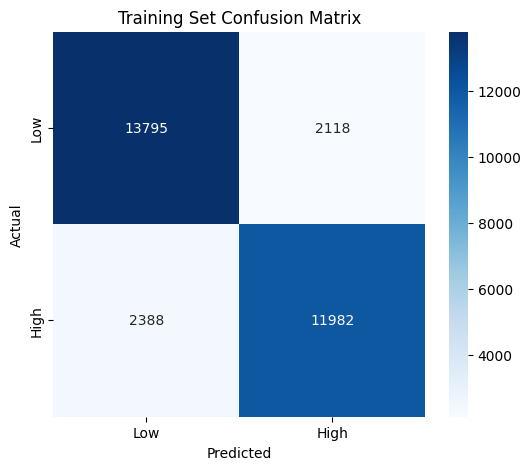


Test Set Metrics
Accuracy: 0.847
Macro Precision: 0.848
Macro Recall: 0.846
Macro F1 Score: 0.846

Detailed Classification Report:
              precision    recall  f1-score   support

        High      0.853     0.819     0.836      3592
         Low      0.842     0.873     0.857      3979

    accuracy                          0.847      7571
   macro avg      0.848     0.846     0.846      7571
weighted avg      0.847     0.847     0.847      7571




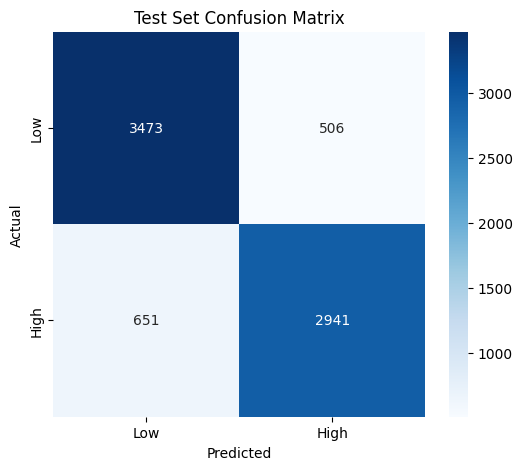

In [19]:
clf_lr = Pipeline([
    ("tfidf", tfidf), # Reuse the TF-IDF vectorizer we defined earlier
    ("logreg", LogisticRegression(
        penalty="l1", # L1 encourages sparse solutions (feature selection)
        solver="liblinear", # Required solver for L1 penalty
        max_iter=500, # More iterations for convergence
        class_weight="balanced", # Adjusts weights inversely to class frequencies
        random_state=SEED, # Reproducibility
        C=0.3 # Smaller C = stronger regularization
    ))
])

# Train the logistic regression model on training data
clf_lr.fit(X_train, y_train)

# Evaluate the model using our helper function
print_metrics(clf_lr, X_train, y_train, X_test, y_test, label="Logistic Regression")

We also train a second model using Multinomial Naive Bayes, a fast and interpretable probabilistic classifier commonly used for text classification. We use a small alpha=0.01 (Laplace smoothing) to make the model more sensitive to subtle differences in word frequency. Again, we use print_metrics() to assess its effectiveness.


Evaluation for: Multinomial Naive Bayes


Training Set Metrics
Accuracy: 0.835
Macro Precision: 0.835
Macro Recall: 0.834
Macro F1 Score: 0.834

Detailed Classification Report:
              precision    recall  f1-score   support

        High      0.832     0.816     0.824     14370
         Low      0.837     0.852     0.844     15913

    accuracy                          0.835     30283
   macro avg      0.835     0.834     0.834     30283
weighted avg      0.835     0.835     0.835     30283




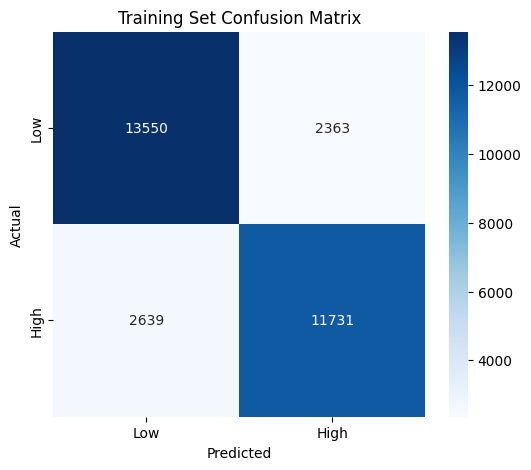


Test Set Metrics
Accuracy: 0.836
Macro Precision: 0.836
Macro Recall: 0.835
Macro F1 Score: 0.835

Detailed Classification Report:
              precision    recall  f1-score   support

        High      0.840     0.808     0.824      3592
         Low      0.833     0.861     0.847      3979

    accuracy                          0.836      7571
   macro avg      0.836     0.835     0.835      7571
weighted avg      0.836     0.836     0.836      7571




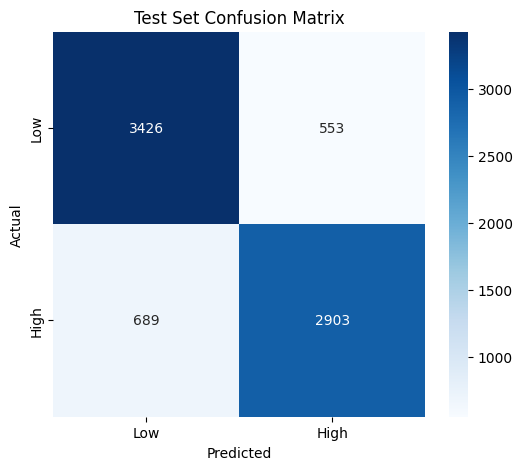

In [20]:
clf_nb = Pipeline([
    ("tfidf", tfidf),
    ("nb", MultinomialNB(alpha=0.01)) # Lower alpha = less smoothing = more sensitivity
])

clf_nb.fit(X_train, y_train)
print_metrics(clf_nb, X_train, y_train, X_test, y_test, label="Multinomial Naive Bayes")

## Token-Level PII Detection with BERT
This section focuses on using BERT to label each token in a document with the type of private information it represents. BERT is ideal here because it processes input contextually, considering the meaning of each word in relation to its neighbors.

We begin by loading a DistilBERT tokenizer and model suited for token classification. The tokenizer breaks text into smaller subword units (tokens), and the model predicts a label for each token, such as B-EMAIL, I-NAME, or O for non-PII.

We also convert our pandas DataFrames into Hugging Face Datasets and create mappings between PII labels and numerical IDs (since the model operates on numbers). Then, we align our original word-level labels to the tokenized text, ensuring that each subword inherits the correct BIO tag.

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import evaluate

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased") # Load a pre-trained BERT tokenizer that splits the input into subword tokens

model = AutoModelForTokenClassification.from_pretrained( # Load the DistilBERT model for token classification with output layer size equal to number of unique BIO labels
    "distilbert-base-cased",
    num_labels=len(set(label for seq in df_train["mbert_bio_labels"] for label in seq))
)

def df_to_hf_dataset(df):
    """
    Convert a pandas DataFrame to a Hugging Face Dataset.
    """
    ds = Dataset.from_pandas(df)
    if "__index_level_0__" in ds.column_names:
        ds = ds.remove_columns("__index_level_0__")
    return ds

ds_train_hug = df_to_hf_dataset(df_train)
ds_test_hug = df_to_hf_dataset(df_test)

# Create a sorted list of all label types (BIO tags) found in training data
label_list = sorted(set(label for seq in ds_train_hug["mbert_bio_labels"] for label in seq))
label_to_id = {label: i for i, label in enumerate(label_list)}
id_to_label = {i: label for label, i in label_to_id.items()}

W0526 14:05:45.229000 32300 Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
c:\Users\marco\OneDrive\Desktop\MSc Data Science\Natural Language Processing\v1\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
def align_labels(example):
    """
    Tokenizes the source_text and aligns token-level labels with original word-level BIO tags.
    """
    tokenized = tokenizer(example["source_text"], truncation=True, max_length=128, return_offsets_mapping=True) # Tokenize the raw text and keep track of where each token starts and ends in the original text. We also truncate very long documents to 128 tokens to reduce memory and training time.
    offsets = tokenized.pop("offset_mapping") # Extract the offset mapping (start/end character positions) and remove it from the tokenized dict
    word_labels = example["mbert_bio_labels"] # Grab the original word-level BIO labels (e.g., ["O", "B-EMAIL", "I-EMAIL", "O"])
    token_labels = [] # Will store the final token-level label IDs
    word_idx = 0 # Index pointer for walking through word_labels
    for start, end in offsets:
        if start == end: # If start == end, this is a special token or padding so skip it
            token_labels.append(-100) # Special ignore index used by HuggingFace Trainer
            continue
        while word_idx < len(word_labels) - 1 and start >= offsets[word_idx][1]: # Advance the word index until we reach the word whose span matches this token
            word_idx += 1
        if start < offsets[word_idx][1] and end > offsets[word_idx][0]: # If the token overlaps with a labeled word span, assign its corresponding BIO label
            token_labels.append(label_to_id.get(word_labels[word_idx], label_to_id["O"])) # Default to 'O' if not found
        else:
            token_labels.append(label_to_id["O"]) # If not matched to any span, it’s considered outside (O)
    tokenized["labels"] = token_labels # Attach the aligned token-level labels to the tokenized output
    return tokenized

ds_train_tok = ds_train_hug.map(align_labels)
ds_test_tok = ds_test_hug.map(align_labels)

Map: 100%|██████████| 7571/7571 [00:05<00:00, 1407.85 examples/s]


We cache our tokenized datasets to disk so we don't have to recompute them every time we rerun the notebook.

In [20]:
CACHE_DIR = "./cache/tokenized" # Define a path to cache the tokenized datasets to disk. This avoids repeating the costly tokenization step.
train_cache = os.path.join(CACHE_DIR, "train")
test_cache = os.path.join(CACHE_DIR, "test")

if os.path.isdir(train_cache) and os.path.isdir(test_cache): # If the tokenized datasets are already cached on disk, load them directly.
    ds_train_tok = load_from_disk(train_cache)
    ds_test_tok = load_from_disk(test_cache)
else: # Otherwise, tokenize the datasets from scratch using align_labels()
    ds_train_tok = ds_train_hug.map(align_labels)
    ds_test_tok = ds_test_hug.map(align_labels)
    # Create cache directory if it doesn't exist and save the processed datasets
    os.makedirs(CACHE_DIR, exist_ok=True)
    ds_train_tok.save_to_disk(train_cache)
    ds_test_tok.save_to_disk(test_cache)

Finally, we configure the training arguments, evaluate performance using the seqeval library, and then train and assess our model. For evaluation, we convert token-level predictions into document-level risk labels using the same scoring function defined earlier.

In [28]:
from transformers import Trainer, TrainingArguments, DataCollatorForTokenClassification
import evaluate

training_args = TrainingArguments(
    output_dir="./cache/distilbert_ner", # Save model checkpoints and logs here
    evaluation_strategy="epoch", # Evaluate performance at the end of every epoch
    save_strategy="epoch", # Save a checkpoint at the end of every epoch
    save_total_limit=1, # Keep only the most recent checkpoint (saves disk space)
    logging_dir="./cache/logs", # Directory to store logs
    learning_rate=3e-5, # Learning rate for the AdamW optimizer
    per_device_train_batch_size=16, # Mini-batch size for training and evaluation
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01, # Regularization to avoid overfitting
    load_best_model_at_end=True, # Automatically reload the best checkpoint at end of training
    metric_for_best_model="f1", # Use macro F1 score to determine best model
    logging_steps=50, # Log metrics every 50 steps during training
    report_to="none" # Disable integrations like W&B or TensorBoard
)

seqeval = evaluate.load("seqeval") # This library is specifically designed to evaluate sequence labeling tasks (like NER)


def compute_metrics(p):
    """ 
    Compute evaluation metrics for the model predictions.
    """
    preds = np.argmax(p.predictions, axis=-1) # We convert raw model predictions (logits) into predicted class indices
    labels = p.label_ids # We get the label indices
    # Align predictions and labels, ignoring special tokens
    pred_labels = [[id_to_label[p] for p, t in zip(p_seq, l_seq) if t != -100] for p_seq, l_seq in zip(preds, labels)] 
    true_labels = [[id_to_label[t] for p, t in zip(p_seq, l_seq) if t != -100] for p_seq, l_seq in zip(preds, labels)]
    results = seqeval.compute(predictions=pred_labels, references=true_labels) # Compute entity-level evaluation metrics using seqeval
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"]
    }



trainer = Trainer(
    model=model,
    args=training_args, # All the training configurations
    train_dataset=ds_train_tok, # Tokenized training and test data
    eval_dataset=ds_test_tok,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer), # Ensures batch padding is done correctly
    compute_metrics=compute_metrics # Metric function to evaluate model performance
)

c:\Users\marco\OneDrive\Desktop\MSc Data Science\Natural Language Processing\v1\.venv\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [30]:
from transformers.trainer_utils import get_last_checkpoint

# Before starting training, we check whether there is a previous checkpoint saved. This allows us to resume training instead of starting from scratch (useful in case of interruptions).
checkpoint = None
if os.path.isdir(training_args.output_dir):
    checkpoint = get_last_checkpoint(training_args.output_dir)

trainer.train(resume_from_checkpoint=checkpoint)

You are resuming training from a checkpoint trained with 4.36.2 of Transformers but your current version is 4.39.3. This is not recommended and could yield to errors or unwanted behaviors.
  0%|          | 0/1893 [01:59<?, ?it/s]

  0%|          | 0/1893 [00:00<?, ?it/s]

{'train_runtime': 0.0764, 'train_samples_per_second': 396269.017, 'train_steps_per_second': 24770.903, 'train_loss': 0.0, 'epoch': 1.0}


TrainOutput(global_step=1893, training_loss=0.0, metrics={'train_runtime': 0.0764, 'train_samples_per_second': 396269.017, 'train_steps_per_second': 24770.903, 'train_loss': 0.0, 'epoch': 1.0})

In this phase, we use mbert_bio_labels, which are token-level BIO annotations, as the supervision signal for training our BERT model. These labels mark whether a token is:
- "O" (Outside any entity),
- "B-TAG" (Beginning of a PII entity),
- "I-TAG" (Inside a PII entity).

The goal of the BERT model is to learn to assign these labels to each token — not to classify full documents. This is a Named Entity Recognition (NER) task.

Later, we aggregate the predicted BIO tags into higher-level entity tags (like "EMAIL", "USERNAME", "SSN") using simple rules:
- We strip the "B-" or "I-" prefixes and group the spans.
- We then compute document-level risk scores using the original privacy_mask structure and our manual risk weights.
- These risk scores are finally converted into "Low" or "High" document risk labels.

In [31]:
def evaluate_risk(trainer, dataset, label="Test Set"):
    """ 
    Evaluate the risk prediction model on a given dataset and print metrics.
    """
    output = trainer.predict(dataset) # Run the model on the test dataset

    preds = np.argmax(output.predictions, axis=-1) # Extract predictions and true labels
    labels = output.label_ids
    pred_risks, true_risks = [], []

    for pred_seq, label_seq in zip(preds, labels): # Iterate over each predicted and true label sequence
        pred_tags, true_tags = [], []
        for p, t in zip(pred_seq, label_seq): # For each token, include it only if it's not a padding/special token (-100)
            if t != -100:
                pred_tags.append(id_to_label[p]) # Predicted label
                true_tags.append(id_to_label[t]) # Actual label

        def strip_bio(tag): # Remove BIO prefixes from labels (e.g., 'B-EMAIL' → 'EMAIL')
            return tag.split("-")[-1] if "-" in tag else tag

        pred_clean = [strip_bio(tag) for tag in pred_tags if tag != "O"]
        true_clean = [strip_bio(tag) for tag in true_tags if tag != "O"]

        def compute_risk(tags): # Compute a document-level risk category by summing weighted tag values and using the cutoff originally defined
            score = sum(pii_weights.get(tag, 1) for tag in tags)
            return "Low" if score <= cutoff else "High"

        pred_risks.append(compute_risk(pred_clean))
        true_risks.append(compute_risk(true_clean))

    # Print metrics
    print(f"\n{label} Metrics:")
    print(f"Accuracy: {accuracy_score(true_risks, pred_risks):.3f}")
    print(f"Macro Precision: {precision_score(true_risks, pred_risks, average='macro'):.3f}")
    print(f"Macro Recall: {recall_score(true_risks, pred_risks, average='macro'):.3f}")
    print(f"Macro F1 Score: {f1_score(true_risks, pred_risks, average='macro'):.3f}")
    print("\nClassification Report:")
    print(classification_report(true_risks, pred_risks, digits=3))

    # Plot confusion matrix
    cm = confusion_matrix(true_risks, pred_risks, labels=["Low", "High"])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Low", "High"], yticklabels=["Low", "High"])
    plt.title(f"{label} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

c:\Users\marco\OneDrive\Desktop\MSc Data Science\Natural Language Processing\v1\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 1893/1893 [12:25<00:00,  2.26it/s]c:\Users\marco\OneDrive\Desktop\MSc Data Science\Natural Language Processing\v1\.venv\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 1893/1893 [12:48<00:00,  2.46it/s]



Training Set Metrics:
Accuracy: 0.900
Macro Precision: 0.852
Macro Recall: 0.928
Macro F1 Score: 0.877

Classification Report:
              precision    recall  f1-score   support

        High      0.993     0.876     0.930     23065
         Low      0.711     0.980     0.824      7218

    accuracy                          0.900     30283
   macro avg      0.852     0.928     0.877     30283
weighted avg      0.926     0.900     0.905     30283



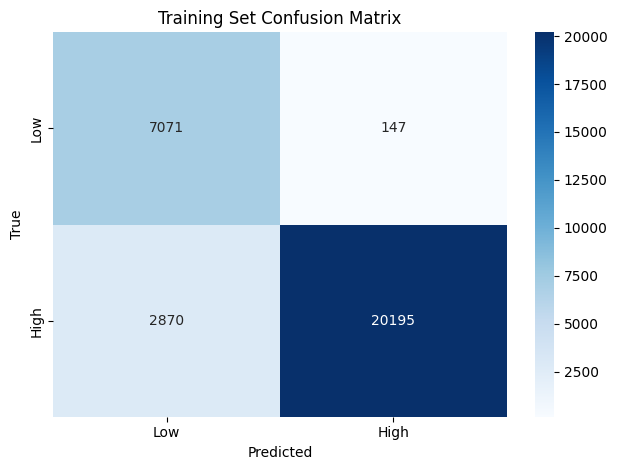

c:\Users\marco\OneDrive\Desktop\MSc Data Science\Natural Language Processing\v1\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|█████████▉| 473/474 [02:43<00:00,  2.81it/s]c:\Users\marco\OneDrive\Desktop\MSc Data Science\Natural Language Processing\v1\.venv\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 474/474 [02:49<00:00,  2.80it/s]



Test Set Metrics:
Accuracy: 0.896
Macro Precision: 0.847
Macro Recall: 0.925
Macro F1 Score: 0.873

Classification Report:
              precision    recall  f1-score   support

        High      0.993     0.870     0.927      5773
         Low      0.701     0.981     0.818      1798

    accuracy                          0.896      7571
   macro avg      0.847     0.925     0.873      7571
weighted avg      0.924     0.896     0.901      7571



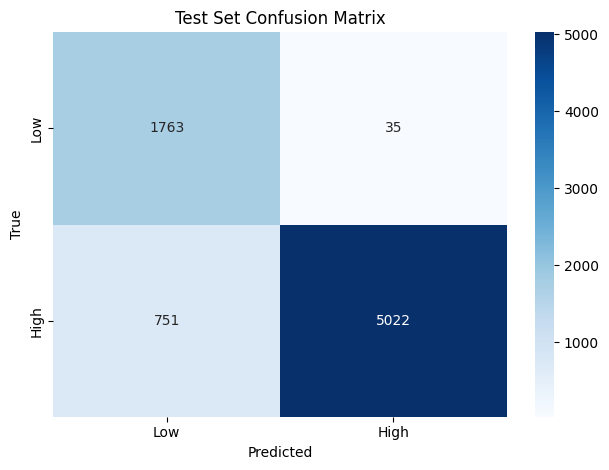

In [34]:
evaluate_risk(trainer, ds_train_tok, label="Training Set") # Evaluate the risk prediction model on the training set to check for overfitting
evaluate_risk(trainer, ds_test_tok)

##  GPT-3.5 API for PII prediction
In this section, we experiment with using the OpenAI GPT-3.5 API to detect and count different types of PII (Personally Identifiable Information) in a document. Rather than fine-tuning a model, we use GPT-3.5 in a zero-shot setup by crafting a prompt that describes the task and asks the model to return a structured JSON output.

We first define the list of PII types we want the model to detect. Then, we format this list into a markdown-style bullet list to include in our prompt. Finally, we write a clear and constrained instruction prompt that tells GPT exactly how to read the document and what format the response should follow. This approach allows us to evaluate whether a general-purpose language model can help with privacy-related labeling tasks without further training.

In [ ]:
# !pip install openai python-dotenv tqdm --quiet


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from dotenv import load_dotenv # Used to securely load environment variables from a .env file (used for our OpenAI API key)
from openai import OpenAI

load_dotenv() # Load environment variables from .env containing OPENAI_API_KEY
api_key = os.getenv("OPENAI_API_KEY")

client = OpenAI(api_key=api_key) # Create a client instance using the loaded API key

# Re-define the PII types to match the labels used in the dataset
PII_TYPES = [
    "PASS", "PASSWORD", "CARDISSUER", "SSN", "DRIVERLICENSE", "PASSPORT", "IDCARD",
    "EMAIL", "TEL", "BOD", "GIVENNAME1", "GIVENNAME2", "LASTNAME1",
    "LASTNAME2", "LASTNAME3", "IP", "SECADDRESS", "GEOCOORD",
    "USERNAME", "TIME", "DATE", "CITY", "STATE", "POSTCODE",
    "TITLE", "SEX", "COUNTRY", "BUILDING", "STREET"
]

In [ ]:
# Format the list of PII types into a clean string that will be inserted into the prompt
pii_list = "\n".join([f"- {pii}" for pii in PII_TYPES])

# Define prompt template with placeholders
prompt_template = (
    "You are a data privacy assistant. Your task is to read the following text and count how many times each of the following PII (Personally Identifiable Information) types appears:\n\n"
    "{pii_list}\n\n"
    "Return only a JSON dictionary where each key is one of the PII types above and each value is the number of occurrences in the text.\n"
    "If a type does not appear, still include it with a count of 0.\n"
    "Do not return anything other than the JSON.\n\n"
    "Text:\n\"\"\"\n{document_text}\n\"\"\"\n\n"
    "JSON answer:"
)

We now send each document to OpenAI's GPT-3.5 API and ask it to count how many instances of each PII type are present in the text. We provide it with a detailed prompt and enforce a strict JSON response format. We then apply the same risk scoring mechanism as before using our pii_weights, and compare GPT-3.5’s predictions to our original rule-based risk labels.

In [ ]:
from tqdm import tqdm
import json
import time

pii_counts = [] # List to store GPT-3.5 responses per document

for i, text in tqdm( # Loop through each document and query ChatGPT
    enumerate(df_test["clean_text"]), # Series mentioned above
    total=len(df_test),
    desc="Scanning with ChatGPT"):
    
    prompt = prompt_template.format(pii_list=pii_list, document_text=text) # Build the final prompt by inserting the document text and the list of PII types into the template

    try:
        response = client.chat.completions.create( # Send the prompt to OpenAI’s Chat Completions endpoint
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0 # Minimal randomness as the model should always return the same JSON structure
        )
        reply = response.choices[0].message.content.strip()
    except Exception as e:
        print(f"[ERROR index {i}] API call failed: {e}")
        pii_counts.append(None) # Store placeholder for failed request
        continue

    try:
        parsed = json.loads(reply) # Try to parse the reply into a dictionary
        complete_dict = {pii: parsed.get(pii, 0) for pii in PII_TYPES} # Fill in any missing PII types with 0 — this ensures consistency across rows
        pii_counts.append(complete_dict)
    except json.JSONDecodeError: # Handle unexpected responses from GPT that can't be parsed as JSON
        print(f"Error at index: {i}. Raw output:\n{reply}")
        pii_counts.append(None)

    time.sleep(0.2) # Sleep to avoid hitting rate limits

Scanning with ChatGPT: 100%|██████████| 7571/7571 [6:19:10<00:00,  3.00s/it]   


Now we take GPT's output (a dictionary of PII counts per document), and apply the same risk scoring and classification logic we used in our rule-based approach. This lets us evaluate how well ChatGPT estimates risk in practice.

In [ ]:
df_test_llm = df_test.copy() # Work on a copy of df_test so we don't modify the original dataset
df_test_llm["llm_detected_pii"] = pii_counts # Attach raw dictionary of PII counts to each row

for pii in PII_TYPES: # For each PII type, create a new column with the number of times GPT said it appears
    df_test_llm[f"count_{pii}"] = df_test_llm["llm_detected_pii"].apply(
        lambda d: d.get(pii, 0) if isinstance(d, dict) else 0
    )
    
# Compute numeric risk score using the same weights as before
df_test_llm["llm_risk_score"] = 0
for pii in PII_TYPES:
    weight = pii_weights.get(pii, 1)
    df_test_llm["llm_risk_score"] += df_test_llm[f"count_{pii}"] * weight

# Classify each document as "Low" or "High" based on the same cutoff used earlier
df_test_llm["llm_risk_label"] = df_test_llm["llm_risk_score"].apply(
    lambda score: "Low" if score <= cutoff else "High"
)

Finally, we check how well GPT-3.5 agrees with our original ground-truth labels.

Accuracy: 0.784

Classification Report:
              precision    recall  f1-score   support

        High       0.93      0.59      0.72      3592
         Low       0.72      0.96      0.82      3979

    accuracy                           0.78      7571
   macro avg       0.82      0.77      0.77      7571
weighted avg       0.82      0.78      0.78      7571



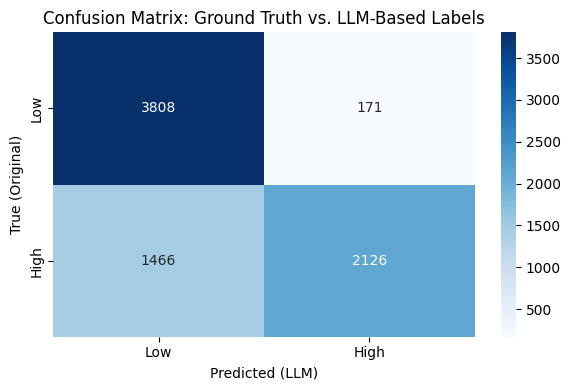

In [ ]:
# Compare predicted labels from LLM against the original labels
accuracy = accuracy_score(df_test_llm["risk_label"], df_test_llm["llm_risk_label"])
print(f"Accuracy: {accuracy:.3f}")

# Print full classification metrics
print("\nClassification Report:")
print(classification_report(df_test_llm["risk_label"], df_test_llm["llm_risk_label"]))

# Show confusion matrix
cm = confusion_matrix(df_test_llm["risk_label"], df_test_llm["llm_risk_label"], labels=["Low", "High"])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Low", "High"], yticklabels=["Low", "High"])
plt.xlabel("Predicted (LLM)")
plt.ylabel("True (Original)")
plt.title("Confusion Matrix: Ground Truth vs. LLM-Based Labels")
plt.tight_layout()
plt.show()